In [1]:
!pip install tmdbsimple

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, json, math, time
import tmdbsimple as tmdb
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)
from tqdm.notebook import tqdm_notebook
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
tmdb.API_KEY = "2e7e239c25274c3cdc1060a9df22dfc7"

In [4]:
def get_movie_with_rating(movie_id):
    movie = tmdb.Movies(movie_id)
    info = movie.info()
    releases = movie.releases()
    for country in releases['countries']:
        if country['iso_3166_1'] == 'US':
            info['certification'] = country['certification']
    return info

In [5]:
get_movie_with_rating(601)

{'adult': False,
 'backdrop_path': '/9Kg322bGsEbmp94LjCCVGz3cpNw.jpg',
 'belongs_to_collection': None,
 'budget': 10500000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 12, 'name': 'Adventure'},
  {'id': 10751, 'name': 'Family'},
  {'id': 14, 'name': 'Fantasy'}],
 'homepage': 'http://www.et20.com/',
 'id': 601,
 'imdb_id': 'tt0083866',
 'original_language': 'en',
 'original_title': 'E.T. the Extra-Terrestrial',
 'overview': 'An alien is left behind on Earth and saved by the 10-year-old Elliot who decides to keep him hidden in his home. While a task force hunts for the extra-terrestrial, Elliot, his brother, and his little sister Gertie form an emotional bond with their new friend, and try to help him find his way home.',
 'popularity': 43.337,
 'poster_path': '/an0nD6uq6byfxXCfk6lQBzdL2J1.jpg',
 'production_companies': [{'id': 33,
   'logo_path': '/8lvHyhjr8oUKOOy2dKXoALWKdp0.png',
   'name': 'Universal Pictures',
   'origin_country': 'US'},
  {'id': 56,
   'logo_path':

In [6]:
def write_json(new_data, filename): 

    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [7]:
basics = pd.read_csv("Data/refined_basics.csv")

In [8]:
YEARS_TO_GET = [2001, 2002]
errors = []

In [9]:
for YEAR in tqdm_notebook(YEARS_TO_GET, desc="YEARS", position=0):
#Defining the JSON file to store results for year
    JSON_FILE=F'{FOLDER}tmdb_api_results_{YEAR}.json'
    #Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    #if it does not exist: create it
    if file_exists==False:
        #print a message indicating the file is being created
        print(f"Creating {JSON_FILE} for API results for {YEAR}.")
        #save an empty dict with just "imdb_id" to the new json file
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
        #Saving new year as the current df
        df=basics.loc[basics["startYear"]==YEAR].copy()
        #saving movie ids to separate variable
        movie_ids=df["tconst"].copy()
        movie_ids
        
        #load existing data from json into a dataframe alled "previous_df"
        previous_df=pd.read_json(JSON_FILE)
        
        previous_df

        #filter out any ids that are already in the JSON_FILE
        movie_ids_to_get=movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

        #Loop through movie_ids_to_get with a tqdm progress bar
        for movie_id in tqdm_notebook(movie_ids_to_get,
                                      f"Movies from {YEAR}"):
        
            #get index and movie id from list
            try:
                #Retrieve then data for the movie id
                temp=get_movie_with_rating(movie_id)
                #append/extend results to existing fil using a pre_made function
                write_json(temp,JSON_FILE)
                #short 20 ms sleep to prevent overwhelming server
                time.sleep(.02)
        
            except Exception as e:
                errors.append([movie_id,e])
                continue
            final_year_df=pd.read_json(JSON_FILE)
            final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip",index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Creating Data/tmdb_api_results_2001.json for API results for 2001.


Movies from 2001:   0%|          | 0/9753 [00:00<?, ?it/s]

Creating Data/tmdb_api_results_2002.json for API results for 2002.


Movies from 2002:   0%|          | 0/11149 [00:00<?, ?it/s]

In [10]:
print(f' - Total Errors occurred: {len(errors)}')

 - Total Errors occurred: 14615


In [11]:
import glob
tmdb_files = sorted(glob.glob("Data/final_tmdb_data*.csv.gz"))
tmdb_files

['Data\\final_tmdb_data_2001.csv.gz', 'Data\\final_tmdb_data_2002.csv.gz']

In [12]:
df = pd.concat([pd.read_csv(f) for f in tmdb_files] )
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0034413,0.00,NaN,NaN,0.00,"[{'id': 99, 'name': 'Documentary'}]",NaN,"1,022,890.00",en,Youth Gets a Break,...,0.00,20.00,[],Released,NaN,Youth Gets a Break,0.00,0.00,0.00,NaN
2,tt0035423,0.00,/tJLV3BAlHOgscVOrA99Wnb2gAef.jpg,NaN,"48,000,000.00","[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,"11,232.00",en,Kate & Leopold,...,"76,019,048.00",118.00,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.00,6.33,"1,245.00",PG-13
3,tt0114447,0.00,NaN,NaN,0.00,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,"151,007.00",en,The Silent Force,...,0.00,90.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.00,5.00,3.00,NaN
4,tt0116916,0.00,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.00,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,"73,549.00",en,The Dark Mist,...,0.00,101.00,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.00,3.50,2.00,PG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3264,tt9518992,0.00,NaN,NaN,0.00,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,"1,050,724.00",en,Killing Skill,...,0.00,90.00,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,Killing Skill,0.00,0.00,0.00,NaN
3265,tt9606526,0.00,NaN,NaN,0.00,"[{'id': 99, 'name': 'Documentary'}]",NaN,"397,979.00",es,1932: Cicatriz de la memoria,...,0.00,54.00,[],Released,NaN,1932: Scars of Memory,0.00,0.00,0.00,NaN
3266,tt9660174,0.00,NaN,NaN,0.00,"[{'id': 99, 'name': 'Documentary'}]",http://www.cobra-films.be/ftedetails.php?id=33,"505,735.00",fr,Racines lointaines,...,0.00,72.00,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Faraway Roots,0.00,0.00,0.00,NaN
3267,tt9686338,0.00,NaN,NaN,0.00,[],NaN,"301,736.00",en,A Tom Tom Chaser,...,0.00,11.00,[],Released,NaN,A Tom Tom Chaser,0.00,0.00,0.00,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6289 entries, 0 to 3268
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                6289 non-null   object 
 1   adult                  6287 non-null   float64
 2   backdrop_path          2447 non-null   object 
 3   belongs_to_collection  457 non-null    object 
 4   budget                 6287 non-null   float64
 5   genres                 6287 non-null   object 
 6   homepage               481 non-null    object 
 7   id                     6287 non-null   float64
 8   original_language      6287 non-null   object 
 9   original_title         6287 non-null   object 
 10  overview               6109 non-null   object 
 11  popularity             6287 non-null   float64
 12  poster_path            5278 non-null   object 
 13  production_companies   6287 non-null   object 
 14  production_countries   6287 non-null   object 
 15  rele

In [23]:
df.to_csv(f"tmdb_results_combined.csv.gz", compression="gzip",index=False)

## How many movies are there in each of the certification categories?

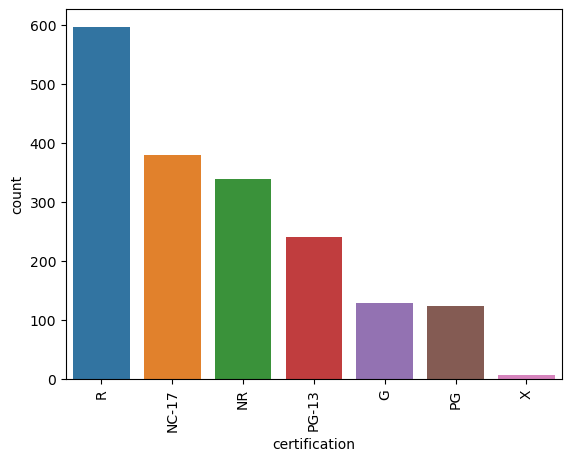

In [15]:
order = df['certification'].value_counts().index
ax = sns.countplot(data=df, x='certification', order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [16]:
certification_count = df['certification'].value_counts()
r = 0
for value in certification_count.index:
    print(f"{value} certifications has {certification_count.values[r]} movies.")
    r += 1

R certifications has 596 movies.
NC-17 certifications has 380 movies.
NR certifications has 338 movies.
PG-13 certifications has 240 movies.
G certifications has 129 movies.
PG certifications has 123 movies.
X certifications has 7 movies.


### How many movies had at least some valid financial information (values > 0 for budget OR revenue)?

In [17]:
movies_with_financials = (df['revenue'] > 0) | (df['budget'] > 0)
movies_with_financials.sum()

870

There are 727 movies that had valid financial information for either revenue or budget.

### What is the average revenue per certification category?

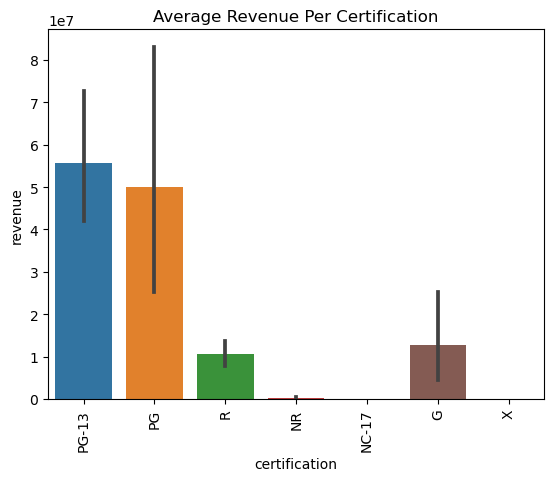

In [18]:
ax = sns.barplot(data=df, x='certification', y='revenue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set(title="Average Revenue Per Certification");

In [19]:
certification_group = df.groupby('certification')

In [20]:
certification_group['revenue'].mean()

certification
G       12,745,472.05
NC-17            0.00
NR         171,273.75
PG      50,128,218.84
PG-13   55,776,057.98
R       10,578,655.06
X                0.00
Name: revenue, dtype: float64

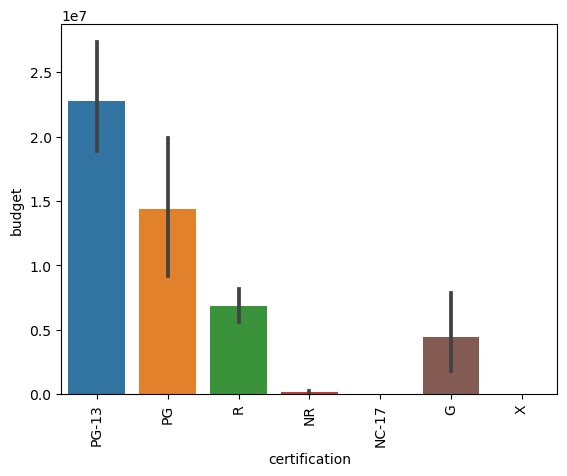

In [21]:
ax = sns.barplot(data=df, x='certification', y='budget')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [22]:
budget_group = df.groupby('budget')
certification_group['budget'].mean()

certification
G        4,394,320.66
NC-17           65.79
NR         115,455.80
PG      14,389,611.83
PG-13   22,793,911.82
R        6,798,530.60
X                0.00
Name: budget, dtype: float64